In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!tar xf drive/MyDrive/Colab\ Notebooks/data/mnist-png-format.tar.xz -C /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Enable CUDA for GPU acceleration 


In [24]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


Import data in PNG form and split into Train, Test, Validate and load


In [25]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose, Grayscale

train_set = '/content/mnist-png-format/train'
test_set = '/content/mnist-png-format/test'
 
batch_size = 256
workers = 2

transforms = Compose([
                        Grayscale(num_output_channels=1),   # PNG file is RGB 3 layer convert to greyscal 1 layer
                        ToTensor(),           
                        Normalize(mean=(0.5), std=(0.5)), 
                        ])

train_dataset = ImageFolder(train_set, transform=transforms)
test_dataset = ImageFolder(test_set, transform=transforms)

# Split Train dataset set into two (Train=85/Validation=15% split)
train_size = int(len(train_dataset) * 0.85) 
validation_size = (len(train_dataset) - train_size) 
train, validation = random_split(train_dataset, [train_size, validation_size])

# load data into usable format, mix/shuffle data so data is not in order 
train_data = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory=True)
val_data  = DataLoader(validation, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory=True)
test_data  = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory=True)

In [26]:
from torch import nn, optim

class SingleLayerModel(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.hidden_1 = nn.Linear(28*28, neurons) # 28x28 Input image, number of neurons
        self.output = nn.Linear(neurons, 10) # 10 class output 0-9


    def forward(self, x):
        x = x.view(x.shape[0], -1) 
        x = nn.functional.relu(self.hidden_1(x))
        y = self.output(x)
        return y

In [59]:
# Optimisable parameters
learning_rate = [0.0001, 0.001, 0.01]
train_epochs = 7
neurons = [10, 30, 50, 100]

ModelMLP  = SingleLayerModel(neurons[2])
optimiser = optim.Adam(ModelMLP.parameters(), lr=learning_rate[1])
loss_func = nn.CrossEntropyLoss()

In [60]:
def evaluate_model(model, eval_dataset):
    model = model.to(device)
    model.eval() # Set model mode to evaluation not training
    correct_batch = 0
    loss_batch = 0
    with torch.no_grad():                 # Gradient graph not require for evaluation should reduce memory usage
      for (imgs, labels) in eval_dataset: # loop through each batch
        imgs, labels = imgs.to(device), labels.to(device)

        pred_y = model(imgs)
        loss = loss_func(pred_y, labels)

        pred = torch.max(pred_y, 1)[1]
        correct_batch += (pred == labels).sum().item() # Calculate correct prediction where prediction == label 
        loss_batch += loss.item()

    return correct_batch / len(eval_dataset.dataset), loss_batch / len(eval_dataset.dataset)

In [61]:
train_acc, train_loss = [], []
val_acc,   val_loss   = [], []

ModelMLP = ModelMLP.to(device)
  
for i in range(train_epochs): # training epochs
  correct_batch = 0
  loss_batch    = 0

  for (imgs, labels) in train_data: # loop through each batch 
    imgs, labels = imgs.to(device), labels.to(device)
    ModelMLP.train()
    pred_y = ModelMLP(imgs)
    loss = loss_func(pred_y, labels)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    pred = torch.max(pred_y, 1)[1]
    correct_batch += (pred == labels).sum().item() # Calculate correct prediction where prediction == label 
    loss_batch += loss.item()

  v_acc, v_loss = evaluate_model(ModelMLP, val_data)
  val_acc.append(v_acc)
  val_loss.append(v_loss)
  train_acc.append(correct_batch / len(train_data.dataset))
  train_loss.append(loss_batch / len(train_data.dataset))

  print('Train accuracy = {0:.2%}, Train loss = {1:.6f} \
          Validation accuracy = {2:.2%}, Validation loss = {3:.6f}'.format(train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1] ))


Train accuracy = 82.93%, Train loss = 0.002605           Validation accuracy = 88.90%, Validation loss = 0.001470
Train accuracy = 90.40%, Train loss = 0.001296           Validation accuracy = 89.69%, Validation loss = 0.001340
Train accuracy = 91.45%, Train loss = 0.001154           Validation accuracy = 91.30%, Validation loss = 0.001174
Train accuracy = 92.18%, Train loss = 0.001056           Validation accuracy = 92.13%, Validation loss = 0.001075
Train accuracy = 92.71%, Train loss = 0.000976           Validation accuracy = 92.76%, Validation loss = 0.000994
Train accuracy = 93.41%, Train loss = 0.000893           Validation accuracy = 93.41%, Validation loss = 0.000922
Train accuracy = 93.94%, Train loss = 0.000835           Validation accuracy = 93.28%, Validation loss = 0.000892


In [62]:
test, _ = evaluate_model(ModelMLP, test_data)
print('Test accuracy = {0:.2%}'.format(test))

Test accuracy = 93.90%


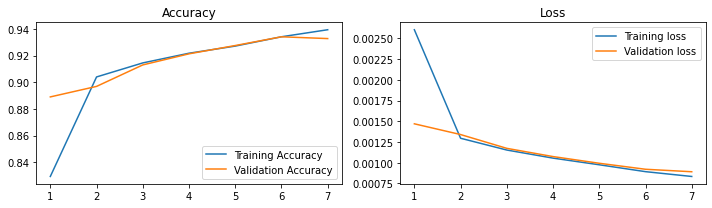

In [80]:
import matplotlib.pyplot as plt

def plot(t_acc, v_acc, t_loss, v_loss):
  epochs = [*range(1,len(t_acc)+1, 1)]

  fig, axes = plt.subplots(1,2, figsize=(10,3))
  axes[0].plot(epochs, t_acc, label='Training Accuracy')
  axes[0].plot(epochs, v_acc, label='Validation Accuracy')
  axes[0].set_title('Accuracy')
  axes[0].legend()
 
  axes[1].plot(epochs, t_loss, label='Training loss')
  axes[1].plot(epochs, v_loss, label='Validation loss')
  axes[1].set_title('Loss')
  axes[1].legend()

  fig.tight_layout()
  plt.show()

plot(train_acc, val_acc, train_loss, val_loss)
